# ICA - 2026

## Introduction

### Setup

We begin with setting up the notebook with the necessary Python libraries, paths to directories, and finally a global theme for the plots.

In [16]:
import os
import random
from pathlib import Path
from glob import glob

import pandas as pd
import plotnine as p9

# Set random seed for reproducibility
# why 42? because 42 is the answer to life, the universe and everything (The Hitchhiker's Guide to the Galaxy)
random.seed(42)

# Please change this path to your own data directory
CONVERSATIONS = "data/conversations"

p9.theme_set(
    p9.theme_minimal() + 
    p9.theme(
        figure_size=(10, 5),
        panel_background = p9.element_rect(fill='white'),
        plot_background = p9.element_rect(fill='white'),
        plot_title=p9.element_text(color='black', size=16, weight='bold'),
        axis_line=p9.element_line(color='black'),
        axis_title=p9.element_text(color='black', size=14),
        axis_text=p9.element_text(color='black', size=12),
        axis_ticks=p9.element_line(color='black')
    )
)

## -- [Write about the software architecture here] --

Write about how we make use of ConvoKit in this iteration of the package. However we intend to reimplement some of the core infrastructure from scratch to avoid dependencies and also customize it for our needs.

We also provide a commandline interface -- describe this in detail

## Load your dataset

We first begin with converting our dataset to a ConvoKit-friendly format, so that it's easily consumable and transformed into necessary representations. An easy to use extend template available `convodynamics/converter/base.py` and an off-the-shelf implementation for CANDOR corpus at `convodynamics/converter/candor.py`. Users can bring their own datasets and convert it to the format using the function calls below.

Announcement: We intend to rmeove this external dependency and streamline it further in the coming iterations of development.

In [ ]:
# converts the CANDOR corpus to ConvoKit format
# Link to original tutorial - https://convokit.cornell.edu/documentation/candor.html
from convodynamics.converters import CandorConverter

converter = CandorConverter(
    datapath=CONVERSATIONS,
    transcript_type="audiophile"
)

folder_name = converter.to_convokit()
print(f"Converted CANDOR corpus to ConvoKit format at folder: {CONVERSATIONS}/{folder_name}")

Converted CANDOR corpus to ConvoKit format at folder: data/conversations/candor_audiophile


The conversations are converted into the required format and stored in the above folder. You can view them with the command below.

In [1]:
!ls -lh {CONVERSATIONS}/{folder_name}

ls: cannot access '{CONVERSATIONS}/{folder_name}': No such file or directory


In [7]:
from convokit import Corpus

# load the converted corpus
corpus = Corpus(filename=Path(CONVERSATIONS) / folder_name)

### Let's begin with visualizing the waveform for a random conversation.

By default we don't load in the conversation audio into memory (`.mp3` file) and instead assume that the user would work with the transcripts due to it's ease of use.

In [11]:
import torchaudio

# get random conversation and it's audio file
random_conversation = corpus.random_conversation()
audio_file = random_conversation.retrieve_meta("audio_file")

# load the audio file into memory using torchaudio
yt, sr = torchaudio.load(audio_file)

# Print audio file details
print("Number of channels:", yt.shape[0])
print("Number of samples:", yt.shape[1])
if yt.shape[0] > 1:
    yt = yt.mean(dim=0) # Convert to mono by averaging channels if stereo

print("Sample rate:", sr)
print("Duration (minutes):", yt.shape[0] / sr / 60)

/home/ssubrahmanya/candor/.venv/lib/python3.9/site-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.


Number of channels: 2
Number of samples: 105024600
Sample rate: 48000
Duration (minutes): 36.466874999999995


Professional grade audio use a default sampling rate of 48KHz (like here). We might have to use a smaller sampling rate, just so that it's easier to plot the waveform.

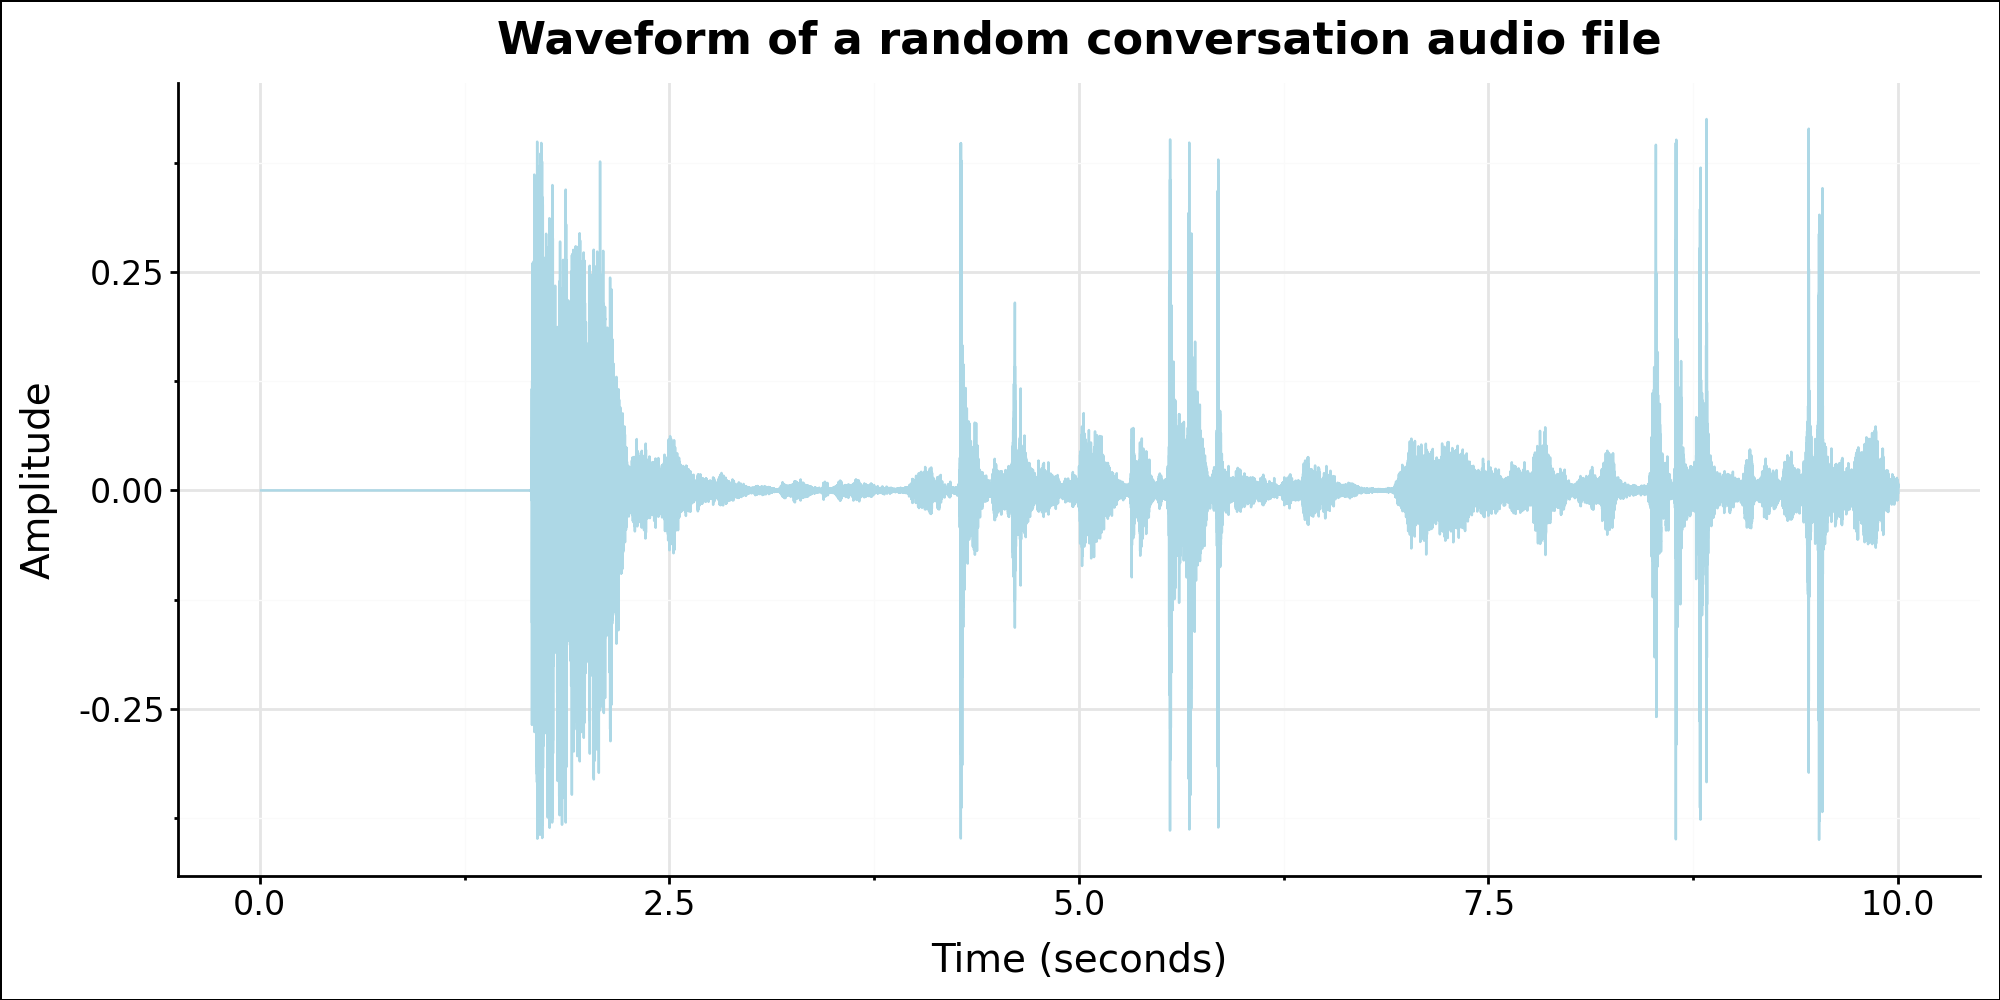

In [15]:
def plot_waveform(yt, sr, start=0, end=None):
    
    if end is None: end = yt.shape[0]
    
    points = pd.DataFrame({
        "Sample Index": range(start, end),
        "Time": [i / sr for i in range(start, end)],
        "Amplitude": yt[start:end]
    })
    
    plot = (
        p9.ggplot(points, p9.aes(x="Time", y="Amplitude"))
        + p9.geom_line(color="lightblue", size=0.5)
        + p9.labs(
            title="Waveform of a random conversation audio file", 
            x="Time (seconds)", 
            y="Amplitude")
    )

    return plot

# Plot the first 10 seconds of the audio
start = 0
end = sr * 10 # 10 seconds
plot_waveform(yt, sr, start, end)

It's not obvious from this waveform that who spoke during it's speech utterrance, no turn-taking information. So, if a user wants to analyze a conversation audio, existing methods involve either transcribing the audio (which CANDOR already does for you) or diarize the audio. In fact, our primary reference Data preprocessing methods used by [Di Stasi et al. (2023)](https://psycnet.apa.org/record/2024-16512-001).

1. Each negotiation session was recorded as a single file (similar to CANDOR). The authors used [Trint](https://trint.com) software for ASR and generate transcripts to their utterrance, and NLP to annotate the speaker turns -- thus there's a step transcript generation here.

2. In the other method, they recorded separate audio files for both speakers and used Trint for automatic VAD on both files.

[Explain speaker diarization here]

-- what's speaker diarization?
-- we use pyannote.audio to do this
-- model available off-the-shelf through huggingface.

Anouncement: We use an older version of the dependency and the model at the moment. So you might see a lot of deprecation warnings. To be upgraded very soon.

In [17]:
from dotenv import load_dotenv

# necessary transformers for speech diarization
from convodynamics.transformers import SpeechDiarizationTransformer

# load huggingface token to download the model
load_dotenv()

# diarize audio if available
diarizer = SpeechDiarizationTransformer(
    huggingface_token=os.getenv("HUGGINGFACE_TOKEN"),
    diarization_model="pyannote/speaker-diarization-3.1"
)
    
corpus = diarizer.transform(corpus)

/home/ssubrahmanya/candor/.venv/lib/python3.9/site-packages/speechbrain/utils/torch_audio_backend.py:57: UserWarning: torchaudio._backend.list_audio_backends has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/audio/issues/3902 for more information. It will be removed from the 2.9 release. 
/home/ssubrahmanya/candor/.venv/lib/python3.9/site-packages/pyannote/audio/core/io.py:212: UserWarning: torchaudio._backend.list_audio_backends has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/audio/issues/3902 for more information. It will be remov

In [19]:
segments = random_conversation.retrieve_meta("diarization_segments")
segments.head()

# [Ask AI to produce the code]

,start,end,speaker,duration
0,1.650969,2.309094,SPEAKER_03,0.658125
1,60.460344,60.932844,SPEAKER_03,0.472500
2,68.290344,69.387219,SPEAKER_01,1.096875
3,117.329094,117.750969,SPEAKER_02,0.421875
4,117.784719,117.835344,SPEAKER_02,0.050625


## Calculate Conversation Dynamics metrics

-- [Describe Table 1 from Di Stasi et al (2024)]

We provide implementation of all of these metrics in `convodynamics/transformers/converstion_dynamics`. Similar to `convertors`, we provide a template that demonstrates how to include your own metrics.

In [20]:
# necessary transformers for the calculating metrics
from convodynamics.transformers import ConversationDynamicsTransformer

# extract conversation dynamics features from Di Stasi et al (2024)
dynamics_extractor = ConversationDynamicsTransformer()
dynamics_extractor.register_metrics([
    "speaking_time",
    "turn_length",
    "pauses",
    # "speaker_rate",
    # "backchannels",
    # "response_time"
])

corpus = dynamics_extractor.transform(corpus)

Extracting feature: speaking_time
Extracting feature: turn_length
Extracting feature: pauses


In [21]:
random_conversation.retrieve_meta("conversation_dynamics_features")

{'speaking_time': {'speaker_00_speaking_time': 25.878451334258752,
  'speaker_01_speaking_time': 48.25697979330558,
  'speaker_02_speaking_time': 4.4061391331173825},
 'turn_length': {'speaker_00_turn_length_median': 1.0715625000000273,
  'speaker_01_turn_length_median': 3.408749999999941,
  'speaker_02_turn_length_median': 1.0462499999999864,
  'speaker_00_turn_length_mean': 3.111119505494496,
  'speaker_01_turn_length_mean': 4.7994034090909095,
  'speaker_02_turn_length_mean': 1.752852272727272,
  'speaker_00_turn_length_cv': 1.4093744360895675,
  'speaker_01_turn_length_cv': 1.1078826311225543,
  'speaker_02_turn_length_cv': 1.183873334533108,
  'speaker_01_turn_length_predictability': 0.02693247410562108,
  'speaker_02_turn_length_predictability': 0.090925233978263,
  'turn_length_adaptability': np.float64(-0.18615140362271781)},
 'pauses': {'speaker_00_avg_pause_pct': 0.03986201054521681,
  'speaker_01_avg_pause_pct': 0.013072651550208586,
  'speaker_02_avg_pause_pct': 0.148640500

In [ ]:
# Prepare waveform data
points = pd.DataFrame({
    "Sample Index": range(start, end),
    "Time": [i / sr for i in range(start, end)],
    "Amplitude": yt[start:end]
})

# Prepare segment data for plotting (only those within the plotted range)
segments_plot = segments.loc[(segments['end'] > points['Time'].min()) & (segments['start'] < points['Time'].max())]
segments_plot['start'] = segments_plot['start'].clip(lower=points['Time'].min())
segments_plot['end'] = segments_plot['end'].clip(upper=points['Time'].max())

# Assign a color to each speaker
# speakers = segments_plot['speaker'].unique()
speaker_colors = {s: c for s, c in zip(segments_plot['speaker'].unique(), ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728"])}

# Plot
(
    p9.ggplot(points, p9.aes(x="Time", y="Amplitude"))
    + p9.geom_line(color="black", size=0.5)
    + p9.geom_rect(
        data=segments_plot,
        mapping=p9.aes(xmin="start", xmax="end", ymin=-1, ymax=1, fill="speaker"),
        alpha=0.2,
        inherit_aes=False
    )
    + p9.scale_fill_manual(values=speaker_colors)
    + p9.labs(
        title="Waveform with Speaker Annotations",
        x="Time (seconds)",
        y="Amplitude",
        fill="Speaker"
    )
)

/tmp/ipykernel_3188658/2968628178.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_3188658/2968628178.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,start,end,speaker,duration
1,6.561594,6.966594,SPEAKER_02,0.405
